In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
import fasttext
import fasttext.util
ft = fasttext.load_model('wiki.hi.bin')

In [4]:
word = "पूरे"
print("Embedding Shape is {}".format(ft.get_word_vector(word).shape))
print("Nearest Neighbors to {} are:".format(word))
ft.get_nearest_neighbors(word) 

Embedding Shape is (300,)
Nearest Neighbors to पूरे are:


[(0.5375568270683289, 'भर'),
 (0.5343677401542664, 'पुरे'),
 (0.49903032183647156, 'सारे'),
 (0.49650809168815613, 'पूरा'),
 (0.49516043066978455, 'समूचे'),
 (0.47405508160591125, 'सम्पूर्ण'),
 (0.4724029302597046, 'भटूरे'),
 (0.46704691648483276, 'अपने'),
 (0.4666309058666229, 'संपूर्ण'),
 (0.46629437804222107, 'ज्\u200d़यादा')]

In [5]:
dataset = pd.read_csv('../Data/Bhaav-Dataset.csv')

In [6]:
dataset

,Sentences,Annotation
0,रमजान के पूरे तीस रोजों के बाद ईद आयी है,1
1,"कितना मनोहर, कितना सुहावना प्रभाव है",1
2,"वृक्षों पर अजीब हरियाली है, खेतों में कुछ अजीब...",1
3,"आज का सूर्य देखो, कितना प्यारा, कितना शीतल है,...",1
4,गाँव में कितनी हलचल है,1
...,...,...
20299,फिर यहाँ सर्दी हो जाती है,4
20300,दिन-भर मैं यह देखती रहती हूँ कि धूप का टुकड़ा क...,4
20301,"पार्क का कोई ऐसा कोना नहीं, जहाँ मैं घड़ी-आधा घ...",4
20302,लेकिन यह बेंच मुझे सबसे अच्छी लगती है,1


### Convert to TF Dataset and Train/Test Split

In [7]:
full_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(dataset['Sentences'].values, tf.string),
            tf.cast(dataset['Annotation'].values, tf.int32)
        )
    )
)

2022-04-28 19:59:04.056154: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
train_size = int(dataset.shape[0]*0.9)

In [9]:
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)

In [10]:
batch_size = 16

In [11]:
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

### Vectorization Layer

In [12]:
max_features = 20000
sequence_length = 200

vectorize_layer = layers.TextVectorization(
    standardize="strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [13]:
train_text = train_dataset.map(lambda x, y: x)

In [14]:
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [16]:
train_ds = train_dataset.map(vectorize_text)
val_ds = test_dataset.map(vectorize_text)

In [17]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [18]:
print ("Words in training set are "+str(len(voc)))

Words in training set are 17889


In [19]:
print ("Words in fasttext vocabulary are "+str(len(ft.words)))

Words in fasttext vocabulary are 158016


### Generate Fasttext embeds

In [20]:
num_tokens = len(voc) + 2
embedding_dim = 300


In [21]:
embedding_matrix = np.zeros((num_tokens, embedding_dim))

In [22]:
fastext_vocab = set(ft.words)

In [23]:
hits = 0
misses = 0

for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    embedding_matrix[i] = embedding_vector
    if word in fastext_vocab:
        hits += 1
    else:
        misses += 1

### Creating embedding layer

In [49]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### Model definition

In [50]:
model = tf.keras.Sequential([
  embedding_layer,
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(5, activation='softmax')])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         5367300   
                                                                 
 dropout_4 (Dropout)         (None, None, 300)         0         
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 1505      
                                                                 
Total params: 5,368,805
Trainable params: 1,505
Non-trainable params: 5,367,300
________________________________________

In [51]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [52]:
epochs = 250
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/250
1143/1143 [==============================] - 3s 3ms/step - loss: 1.3379 - sparse_categorical_accuracy: 0.5731 - val_loss: 1.2364 - val_sparse_categorical_accuracy: 0.5938
Epoch 2/250
1143/1143 [==============================] - 3s 2ms/step - loss: 1.2729 - sparse_categorical_accuracy: 0.5741 - val_loss: 1.2132 - val_sparse_categorical_accuracy: 0.5938
Epoch 3/250
1143/1143 [==============================] - 3s 2ms/step - loss: 1.2594 - sparse_categorical_accuracy: 0.5741 - val_loss: 1.1998 - val_sparse_categorical_accuracy: 0.5938
Epoch 4/250
1143/1143 [==============================] - 3s 3ms/step - loss: 1.2494 - sparse_categorical_accuracy: 0.5741 - val_loss: 1.1905 - val_sparse_categorical_accuracy: 0.5938
Epoch 5/250
1143/1143 [==============================] - 3s 2ms/step - loss: 1.2416 - sparse_categorical_accuracy: 0.5741 - val_loss: 1.1838 - val_sparse_categorical_accuracy: 0.5938
Epoch 6/250
1143/1143 [==============================] - 3s 3ms/step - loss: 1.2360 -

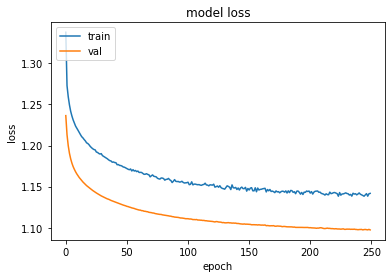

In [53]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
val_softmax = model.predict(val_ds)

In [55]:
val_labels = np.argmax(val_softmax, axis=1)

In [56]:
val_pd = dataset[train_size:]

In [57]:
val_pd['pred_labels'] = val_labels

/var/folders/t_/jx0zym4j5mgf__cxw2drjvwm0000gn/T/ipykernel_57839/905541298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_pd['pred_labels'] = val_labels


In [58]:
val_pd

,Sentences,Annotation,pred_labels
18273,भारत की जनता के लिए यह दुर्भाग्य ही रहा कि ताश...,2,4
18274,11 जनवरी सन्‌ 1966 को इस महान पुरुष का ताशकंद ...,2,4
18275,मरणोपरांत सन्‌ 1966 में उन्हें भारत के सर्वोच्...,1,4
18276,राष्ट्र के विजयी प्रधानमंत्री होने के नाते उनक...,4,4
18277,सरदार वल्लभभाई पटेल का जन्म 31 अक्टूबर 1875 को...,4,4
...,...,...,...
20299,फिर यहाँ सर्दी हो जाती है,4,4
20300,दिन-भर मैं यह देखती रहती हूँ कि धूप का टुकड़ा क...,4,4
20301,"पार्क का कोई ऐसा कोना नहीं, जहाँ मैं घड़ी-आधा घ...",4,4
20302,लेकिन यह बेंच मुझे सबसे अच्छी लगती है,1,4


In [59]:
val_pd['pred_labels'].value_counts()

4    1966
2      56
1       5
0       3
3       1
Name: pred_labels, dtype: int64

In [60]:
val_pd['Annotation'].value_counts()

4    1206
2     403
1     229
3     100
0      93
Name: Annotation, dtype: int64

In [61]:
from sklearn.metrics import classification_report

In [62]:
print (classification_report(val_pd['Annotation'], val_pd['pred_labels']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       1.00      0.02      0.04       229
           2       0.45      0.06      0.11       403
           3       1.00      0.01      0.02       100
           4       0.60      0.98      0.75      1206

    accuracy                           0.60      2031
   macro avg       0.61      0.22      0.18      2031
weighted avg       0.61      0.60      0.47      2031



### LSTM

In [24]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [45]:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(5, activation = 'softmax')
])

In [46]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [47]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
1143/1143 [==============================] - 45s 39ms/step - loss: 1.2495 - sparse_categorical_accuracy: 0.5733 - val_loss: 1.2225 - val_sparse_categorical_accuracy: 0.5938
Epoch 2/20
1143/1143 [==============================] - 43s 38ms/step - loss: 1.2370 - sparse_categorical_accuracy: 0.5741 - val_loss: 1.2142 - val_sparse_categorical_accuracy: 0.5938
Epoch 3/20
1143/1143 [==============================] - 43s 37ms/step - loss: 1.2376 - sparse_categorical_accuracy: 0.5734 - val_loss: 1.2205 - val_sparse_categorical_accuracy: 0.5938
Epoch 4/20
1143/1143 [==============================] - 41s 36ms/step - loss: 1.2423 - sparse_categorical_accuracy: 0.5741 - val_loss: 1.2257 - val_sparse_categorical_accuracy: 0.5938
Epoch 5/20
1143/1143 [==============================] - 41s 36ms/step - loss: 1.2432 - sparse_categorical_accuracy: 0.5741 - val_loss: 1.2270 - val_sparse_categorical_accuracy: 0.5938
Epoch 6/20
1143/1143 [==============================] - 41s 36ms/step - loss: 1.

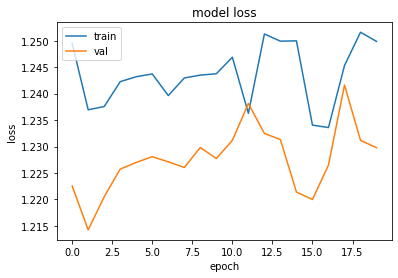

In [48]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()